In [15]:
from skimage.util import img_as_ubyte
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import cv2
import os
from skimage import io
from skimage.feature import peak_local_max
import math
from matplotlib.pyplot import bar
import matplotlib.pyplot as plt
import numpy as np
import glob
import joblib
from sklearn.ensemble import RandomForestClassifier
import mahotas as mt
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [2]:
dictionary = {
    # apple
    0: 'Apple scab',
    1: 'Black rot',
    2: 'apple rust',
    3: 'Apple is healthy',

    # cherry
    5: 'Cherry is healthy',
    6: 'Powdery mildew',

    # corn
    7: 'Gray leaf spot',
    8: 'Common rust',
    9: 'Corn is healthy',
    10: 'Northern Leaf Blight',

    # grape
    11: 'Black rot',
    12: 'Black Measles',
    13: 'Grape is healthy',
    14: 'Leaf blight',

    # peach
    16: 'Bacterial spot',
    17: 'Peach is healthy',

    # pepper
    18: 'Bacterial spot',
    19: 'Pepper is healthy',

    # potato
    20: 'Early blight',
    21: 'Potato is healthy',
    22: 'Late blight',

    # Strawberry
    26: 'Strawberry is healthy',
    27: 'Leaf scorch',

    # Tomato
    28: 'Bacterial spot',
    29: 'Early blight',
    30: 'Tomato is healthy',
    31: 'Late blight',
    32: 'Leaf Moldy',
    33: 'Septoria leaf spot',
    34: 'Two-spotted spider mite',
    35: 'Target Spot disease',
    36: 'Tomato mosaic virus',
    37: 'Tomato Yellow Leaf Curl Virus',
}

In [107]:
x_train = []
y_train = []
nums = []
def label_folder(folder_path, label):
    images = []
    labels = []
    num = 0
    for img_path in os.listdir(folder_path):
        num +=1
        if img_path.endswith('.jpg') or img_path.endswith('.png') or img_path.endswith('.jpeg') or img_path.endswith('.JPG'):
            img = io.imread(str(folder_path)+'/'+str(img_path))
            images.append(img)
            labels.append([label])
        else: 
            print(img_path)

    nums.append(num)
    x_train.extend(images)
    y_train.extend(labels)
    
## load data
for i in range (26, 28):
    folder_path = os.path.join('D://4th year//gp//plantvillage dataset//color', dictionary[i])
    print(dictionary[i])
    label_folder(folder_path , i)

Strawberry___healthy
Strawberry___Leaf_scorch


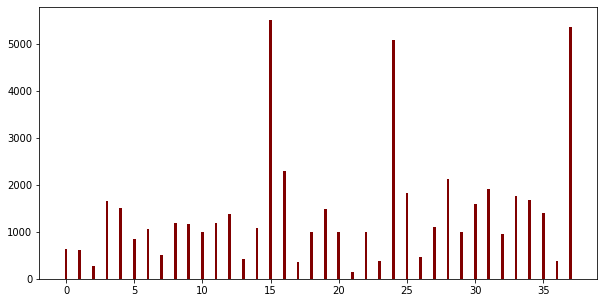

In [9]:

values = list(dictionary.keys())
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, nums, color ='maroon',width = 0.2)
plt.show()

In [6]:
def extract_hu_features(image):
    gray_img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_img)
    huMoments = cv2.HuMoments(moments)
    huMoments_new = []
    for i in range(0,7):
        moment = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
        huMoments_new.append("{:.8f}".format(moment))
    return huMoments_new

In [7]:
def extract_haralick_features(image):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

In [9]:
def AssignBit(image, x, y, c):   
    bit = 0  
    try:          
        if image[x][y] >= c: 
            bit = 1         
    except: 
        pass
    return bit


# takes an image and returns an LBP value
def LocalBinaryValue(image, x, y): 
    eight_bit_binary = []
    centre = image[x][y] 
    powers = [1, 2, 4, 8, 16, 32, 64, 128] 
    decimal_val = 0
    #starting from top right,assigning bit to pixels clockwise 
    eight_bit_binary.append(AssignBit(image, x-1, y + 1,centre)) 
    eight_bit_binary.append(AssignBit(image, x, y + 1, centre)) 
    eight_bit_binary.append(AssignBit(image, x + 1, y + 1, centre)) 
    eight_bit_binary.append(AssignBit(image, x + 1, y, centre)) 
    eight_bit_binary.append(AssignBit(image, x + 1, y-1, centre)) 
    eight_bit_binary.append(AssignBit(image, x, y-1, centre)) 
    eight_bit_binary.append(AssignBit(image, x-1, y-1, centre)) 
    eight_bit_binary.append(AssignBit(image, x-1, y, centre))     
    #calculating decimal value of the 8-bit binary number
    for i in range(len(eight_bit_binary)): 
        decimal_val += eight_bit_binary[i] * powers[i] 

    return decimal_val


# returns histogram of LBP image from gray image 
def extract_LBP_features(image):
    m, n,_= image.shape 
    gray_img = (cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) * 255).astype(np.uint8)  
    lbp_img = np.zeros((m, n),np.uint8) 
  # converting image to lbp
    for i in range(0,m): 
        for j in range(0,n): 
            lbp_img[i, j] = LocalBinaryValue(gray_img, i, j) 
    hist_lbp = np.histogram(lbp_img, bins=20)[0]

    return hist_lbp

In [10]:
gamma = 0.5
sigma = 0.56
theta_list = [0, np.pi, np.pi/2, np.pi/4, 3*np.pi/4] 
phi = 0
lamda_list = [2*np.pi/1, 2*np.pi/2, 2*np.pi/3, 2*np.pi/4, 2*np.pi/5] 
def gabor(img):    
    gray_img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
    local_energy_list=[]
    mean_ampl_list=[]
    for theta in theta_list:                
        for lamda in lamda_list:
            kernel=cv2.getGaborKernel((3,3),sigma,theta,lamda,gamma,phi,ktype=cv2.CV_32F)
            fimage = cv2.filter2D(gray_img.astype(np.uint8), cv2.CV_8UC3, kernel)
            mean_ampl=np.sum(abs(fimage))
            mean_ampl_list.append(mean_ampl)
            local_energy=np.sum(fimage**2)
            local_energy_list.append(local_energy)
            local_energy_list.extend(mean_ampl_list)
    return local_energy_list

In [1]:
def ColorHistogram(img):
    features = []        
    data = np.vstack((img[:,:,0].flat, img[:,:,1].flat, img[:,:,2].flat)).astype(np.uint8).T                                
    hist, _ = np.histogramdd(data, bins=8, range=((0,256),(0,256),(0,256)))
    hist = hist / (np.linalg.norm(hist) + 1e-16)
    hist= hist.flatten()
    features.extend(hist)
    return features

In [25]:
def extract_all(images):
    hu_features = []
    haralick_features = []
    LBP_features = []
    gabor_features = []
    ColorHistogram_features = []
    
    for img in images:
        hu_features.append(extract_hu_features(img))
        haralick_features.append(extract_haralick_features(img))
        LBP_features.append(extract_LBP_features(img))
        gabor_features.append(gabor(img))
        ColorHistogram_features.append(ColorHistogram(img))
        
    return hu_features, haralick_features, LBP_features, gabor_features, ColorHistogram_features
        

In [108]:

hu_features, haralick_features, LBP_features, gabor_features, ColorHistogram_features = extract_all(x_train)

In [109]:
LBP_features = preprocessing.normalize(LBP_features)
hu_features = preprocessing.normalize(hu_features)
haralick_features = preprocessing.normalize(haralick_features)
gabor_features = preprocessing.normalize(gabor_features)
ColorHistogram_features = preprocessing.normalize(ColorHistogram_features)

In [110]:
data_frame = np.hstack((y_train, LBP_features, hu_features, haralick_features, gabor_features, ColorHistogram_features))
np.random.shuffle(data_frame)
percentage = 80
partition = int(len(hu_features)*0.8)

train_valid_images, test_images = data_frame[:partition, 1:], data_frame[partition:, 1:]
train_valid_labels, test_labels = data_frame[:partition, 0].ravel(), data_frame[partition:, 0].ravel()

partition2 = int(len(train_valid_images)*0.8)
train_images, valid_images = train_valid_images[:partition2, :], train_valid_images[partition2:, :]
train_labels, valid_labels = train_valid_labels[0:partition2].ravel(), train_valid_labels[partition2: len(train_valid_labels)].ravel()


## SVM models

In [37]:
## Apple
Apple_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Apple_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  95.47


In [25]:
Apple_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = Apple_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

['models/Apple.joblib']

In [44]:
## cherry
cherry_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = cherry_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+5
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  99.67


In [33]:
cherry_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = cherry_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

['models/cherry.joblib']

In [52]:
## corn
corn_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = corn_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+7
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  93.19


In [ ]:
corn_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = corn_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

In [59]:
## grape 
Grape_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Grape_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+11
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  94.46


In [61]:
grape_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = grape_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+11
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  93.73


In [78]:
## peach
Peach_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Peach_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+16
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  99.53


In [66]:
peach_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = peach_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+16
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

['models/peach.joblib']

In [85]:
## Pepper
Pepper_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Pepper_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+18
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  97.47


In [87]:
Pepper_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = Pepper_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+18
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  96.57


In [101]:
## Potato
Potato_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Potato_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+20
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  97.10


In [102]:
Potato_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = Potato_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+20
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  97.91


In [112]:
## Strawberry
Strawberry_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Strawberry_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+26
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  97.61


In [ ]:
Strawberry_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = Strawberry_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+26
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

In [71]:
## Tomato
Tomato_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_images, train_labels)
total_probabiliy = Tomato_classifier.predict_proba(valid_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+28
valid_labels2 = valid_labels.astype(int)
clf_accuracy = accuracy_score(valid_labels2, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  93.36


In [72]:
Tomato_classifier = svm.SVC(kernel='rbf', degree=3, C=5, probability=True).fit(train_valid_images, train_valid_labels)
total_probabiliy = Tomato_classifier.predict_proba(test_images)
probabiliy_valid = np.argmax(total_probabiliy, axis=1)+28
test_labels = test_labels.astype(int)
clf_accuracy = accuracy_score(test_labels, probabiliy_valid)
print('Accuracy (model): ', "%.2f" % (clf_accuracy*100))

Accuracy (model):  93.42


## RF models

In [38]:
### Apple
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
Apple_clf = voting_clf.fit(train_images, train_labels)
poly_pred = Apple_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  96.46
F1 (Polynomial Kernel):  96.48


In [39]:
Apple_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = Apple_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Apple_file_name = "models/Apple.joblib"
joblib.dump(Apple_clf, Apple_file_name)

Accuracy (Polynomial Kernel):  97.48
F1 (Polynomial Kernel):  97.47


['models/Apple.joblib']

In [45]:
### cherry
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
cherry_clf = voting_clf.fit(train_images, train_labels)
poly_pred = cherry_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  99.67
F1 (Polynomial Kernel):  99.67


In [46]:
cherry_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = cherry_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

cherry_file_name = "models/cherry.joblib"
joblib.dump(cherry_clf, cherry_file_name)

Accuracy (Polynomial Kernel):  99.74
F1 (Polynomial Kernel):  99.74


['models/cherry.joblib']

In [53]:
### corn
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
corn_clf = voting_clf.fit(train_images, train_labels)
poly_pred = corn_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  94.33
F1 (Polynomial Kernel):  93.89


In [54]:
corn_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = corn_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

corn_file_name = "models/corn.joblib"
joblib.dump(corn_clf, corn_file_name)

Accuracy (Polynomial Kernel):  93.90
F1 (Polynomial Kernel):  93.56


['models/corn.joblib']

In [62]:
### grape
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
grape_clf = voting_clf.fit(train_images, train_labels)
poly_pred = grape_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  96.92
F1 (Polynomial Kernel):  96.93


In [63]:
grape_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = grape_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

grape_file_name = "models/grape.joblib"
joblib.dump(grape_clf, grape_file_name)

Accuracy (Polynomial Kernel):  97.79
F1 (Polynomial Kernel):  97.79


['models/grape.joblib']

In [79]:
### peach
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
peach_clf = voting_clf.fit(train_images, train_labels)
poly_pred = peach_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  99.29
F1 (Polynomial Kernel):  99.29


In [80]:
peach_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = peach_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

peach_file_name = "models/peach.joblib"
joblib.dump(peach_clf, peach_file_name)

Accuracy (Polynomial Kernel):  98.68
F1 (Polynomial Kernel):  98.66


['models/peach.joblib']

In [88]:
### pepper
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
pepper_clf = voting_clf.fit(train_images, train_labels)
poly_pred = pepper_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  99.49
F1 (Polynomial Kernel):  99.49


In [89]:
pepper_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = pepper_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

pepper_file_name = "models/pepper.joblib"
joblib.dump(pepper_clf, pepper_file_name)

Accuracy (Polynomial Kernel):  99.60
F1 (Polynomial Kernel):  99.60


['models/pepper.joblib']

In [105]:
### potato
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
potato_clf = voting_clf.fit(train_images, train_labels)
poly_pred = potato_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  93.91
F1 (Polynomial Kernel):  93.86


In [106]:
potato_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = potato_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

potato_file_name = "models/potato.joblib"
joblib.dump(potato_clf, potato_file_name)

Accuracy (Polynomial Kernel):  96.98
F1 (Polynomial Kernel):  96.98


['models/potato.joblib']

In [113]:
### Strawberry
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
Strawberry_clf = voting_clf.fit(train_images, train_labels)
poly_pred = Strawberry_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  100.00
F1 (Polynomial Kernel):  100.00


In [114]:
Strawberry_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = Strawberry_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Strawberry_file_name = "models/strawberry.joblib"
joblib.dump(Strawberry_clf, Strawberry_file_name)

Accuracy (Polynomial Kernel):  100.00
F1 (Polynomial Kernel):  100.00


['models/strawberry.joblib']

In [69]:
### Tomato
voting_clf = RandomForestClassifier(max_depth=60, random_state=0)
Tomato_clf = voting_clf.fit(train_images, train_labels)
poly_pred = Tomato_clf.predict(valid_images)
poly_accuracy = accuracy_score(valid_labels, poly_pred)
poly_f1 = f1_score(valid_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  94.05
F1 (Polynomial Kernel):  93.98


In [73]:
Tomato_clf = voting_clf.fit(train_valid_images, train_valid_labels)
poly_pred = Tomato_clf.predict(test_images)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Tomato_file_name = "models/Tomato.joblib"
joblib.dump(Tomato_clf, Tomato_file_name)

Accuracy (Polynomial Kernel):  94.30
F1 (Polynomial Kernel):  94.25


['models/Tomato.joblib']